In [1]:
from plotly.io import show
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

from skfolio import Population, RiskMeasure
from skfolio.datasets import load_factors_dataset, load_sp500_dataset
from skfolio.moments import GerberCovariance, ShrunkMu
from skfolio.optimization import MeanRisk, ObjectiveFunction
from skfolio.preprocessing import prices_to_returns
from skfolio.prior import EmpiricalPrior, FactorModel, LoadingMatrixRegression
from skfolio.datasets import load_sp500_dataset

prices = load_sp500_dataset()
prices.head()

,AAPL,AMD,BAC,BBY,CVX,GE,HD,JNJ,JPM,KO,LLY,MRK,MSFT,PEP,PFE,PG,RRC,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.264,4.125,4.599,0.144,4.991,14.391,1.117,3.438,3.394,2.235,6.658,4.215,0.384,4.738,1.021,3.860,3.322,0.310,3.653,4.068
1990-01-03,0.266,4.000,4.636,0.161,4.910,14.364,1.121,3.452,3.508,2.203,6.658,4.282,0.386,4.692,1.024,3.853,3.322,0.304,3.653,4.027
1990-01-04,0.267,3.938,4.537,0.159,4.847,14.283,1.128,3.459,3.522,2.192,6.621,4.215,0.397,4.646,1.041,3.777,3.322,0.301,3.634,3.987
1990-01-05,0.268,3.812,4.438,0.159,4.775,14.148,1.113,3.423,3.536,2.174,6.549,4.128,0.387,4.581,1.032,3.709,3.322,0.288,3.595,3.966
1990-01-08,0.269,3.812,4.463,0.147,4.820,14.229,1.102,3.481,3.536,2.220,6.549,4.181,0.393,4.664,1.023,3.777,3.322,0.282,3.644,4.027


Il s'agit d'une version brouillon, la version finale présente des commentaires et 

In [2]:
prices = load_sp500_dataset()
factor_prices = load_factors_dataset()

prices = prices["2014":]
factor_prices = factor_prices["2014":]

X, y = prices_to_returns(prices, factor_prices)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

FACTOR MODEL

In [3]:
model_factor_1 = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    prior_estimator=FactorModel(),
    portfolio_params=dict(name="Factor Model 1"),
)
model_factor_1.fit(X_train, y_train)
model_factor_1.weights_

array([1.22188126e-09, 1.31737525e-03, 4.74251526e-10, 7.70437909e-10,
       9.46433355e-10, 1.24958828e-09, 5.13001762e-02, 6.35652050e-02,
       7.36334382e-10, 1.79104637e-01, 5.03133290e-02, 7.13696569e-02,
       4.12895735e-02, 2.27967880e-01, 5.13346758e-02, 1.44128512e-01,
       2.88141430e-10, 6.19657594e-02, 5.63432134e-02, 1.09849529e-09])

In [10]:
model_factor_2 = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    prior_estimator=FactorModel(
        loading_matrix_estimator=LoadingMatrixRegression(
            linear_regressor=RidgeCV(fit_intercept=False), n_jobs=-1
        )
    ),
    portfolio_params=dict(name="Factor Model 2"),
)
model_factor_2.fit(X_train, y_train)
model_factor_2.weights_

array([3.97776251e-02, 6.57851863e-03, 2.18408031e-02, 8.98298187e-03,
       3.16206283e-02, 1.42391439e-02, 8.00175085e-02, 8.32124541e-02,
       4.74823262e-02, 8.59482205e-02, 4.59789920e-02, 5.91802980e-02,
       8.42282443e-02, 1.05685439e-01, 6.43876113e-02, 7.94746609e-02,
       4.31336000e-08, 5.23719260e-02, 4.35228602e-02, 4.54697150e-02])

In [5]:
model_factor_3 = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    prior_estimator=FactorModel(
        factor_prior_estimator=EmpiricalPrior(
            mu_estimator=ShrunkMu(), covariance_estimator=GerberCovariance()
        )
    ),
    portfolio_params=dict(name="Factor Model 3"),
)
model_factor_3.fit(X_train, y_train)
model_factor_3.weights_

array([4.48239171e-12, 4.49600474e-12, 3.48815556e-13, 5.59824866e-13,
       4.22338690e-13, 5.12441693e-13, 1.68739416e-02, 2.26111874e-11,
       4.33910390e-13, 6.45574521e-02, 6.24004576e-02, 9.61481439e-02,
       3.68197345e-01, 2.44687699e-01, 5.21275615e-12, 8.72707574e-11,
       1.76989054e-13, 1.47134961e-01, 2.66229019e-12, 4.78918191e-13])

In [7]:
prior_estimator = model_factor_3.prior_estimator_
prior_model = prior_estimator.prior_model_
loading_matrix = prior_estimator.loading_matrix_estimator_.loading_matrix_

In [8]:
model_empirical = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    portfolio_params=dict(name="Empirical"),
)
model_empirical.fit(X_train)
model_empirical.weights_

array([1.01562655e-01, 7.81176235e-02, 1.48584879e-11, 1.89116954e-02,
       7.18472382e-12, 3.64548652e-12, 1.10584830e-01, 2.88184085e-11,
       3.64187085e-11, 8.95059584e-11, 1.62632716e-01, 4.66742646e-11,
       1.77784307e-01, 9.61513792e-02, 1.10073341e-11, 9.72248235e-03,
       1.74345654e-12, 2.44532312e-01, 4.38046978e-11, 5.50463675e-12])

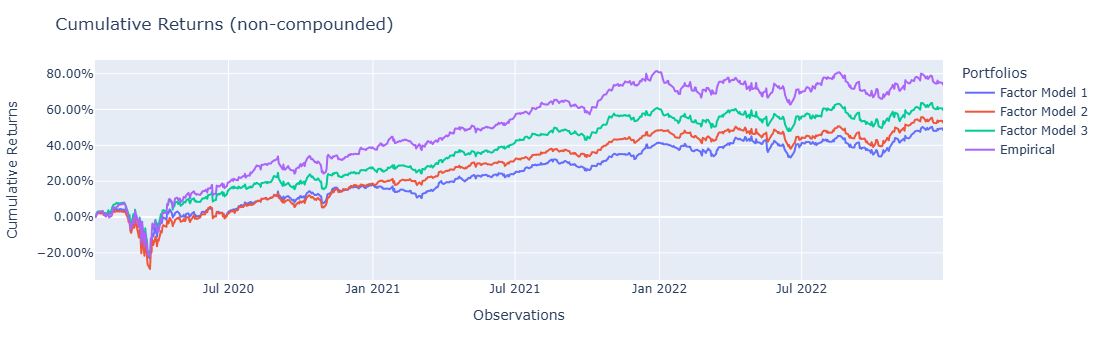

In [13]:
# Affichage historiques
ptf_factor_1_test = model_factor_1.predict(X_test)
ptf_factor_2_test = model_factor_2.predict(X_test)
ptf_factor_3_test = model_factor_3.predict(X_test)
ptf_empirical_test = model_empirical.predict(X_test)

population = Population(
    [ptf_factor_1_test, ptf_factor_2_test, ptf_factor_3_test, ptf_empirical_test]
)

fig = population.plot_cumulative_returns()
show(fig)

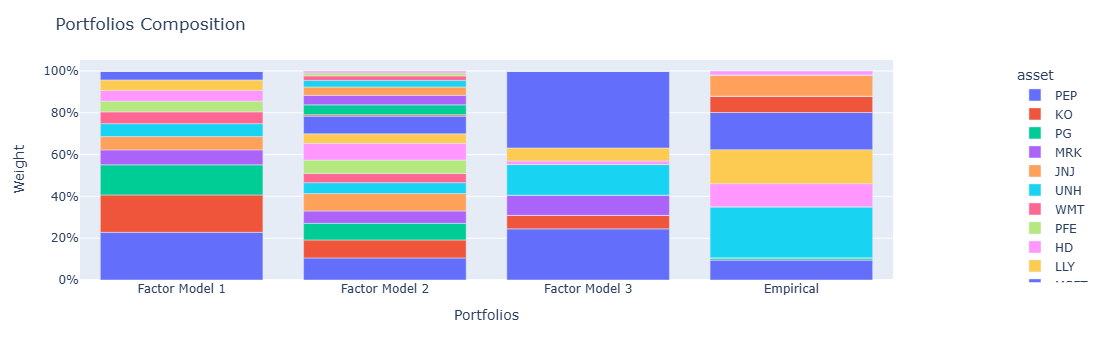

In [14]:
population.plot_composition()